In [2]:
# I just reimplement from github.com/pbcquoc
import warnings
warnings.filterwarnings("ignore")

import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
from random import randint
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [67]:
!nvidia-smi

Tue Aug 15 11:12:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    33W / 250W |   4867MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
! curl --silent -L -o data.zip "https://drive.google.com/uc?export=download&id=1d6eUqRstk7NIpyASzbuIsDvBdHEwfU0g"
! unzip -q data.zip
! ls data

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
data.csv  human_vocab.json  machine_vocab.json


# Preprocess dataset

In [4]:
def load_data(path):
    df = pd.read_csv(path, header=None)
    X = df[0].values
    y = df[1].values
    x_tok = Tokenizer(char_level=True, filters='')
    x_tok.fit_on_texts(X)
    y_tok = Tokenizer(char_level=True, filters='')
    y_tok.fit_on_texts(y)
    
    X = x_tok.texts_to_sequences(X)
    y = y_tok.texts_to_sequences(y)
    
    X = pad_sequences(X)
    y = np.asarray(y)
    
    return X, y, x_tok.word_index, y_tok.word_index

X, y, x_wid, y_wid= load_data('./data/data.csv')
x_id2w = dict(zip(x_wid.values(), x_wid.keys()))
y_id2w = dict(zip(y_wid.values(), y_wid.keys()))
X_train, X_test, y_train, y_test = train_test_split(X, y)
print('train size: {} - test size: {}'.format(len(X_train), len(X_test)))

train size: 18750 - test size: 6250


# Define architect

## hyperparams

In [10]:
batch_size = 64
hidden_size = 128
learning_rate = 0.001
decoder_learning_ratio = 0.1
dropout = 0.1
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# add <pad> for encoder vocab
en_vocab_size = len(x_wid) + 1

# add <sos> and <eos> for decoder vocab
de_vocab_size = len(y_wid) + 2
sos_idx = len(y_wid) 
eos_idx = len(y_wid) + 1

max_length = y.shape[1]
print("input vocab: {} - output vocab: {} - length of target: {}".format(en_vocab_size, de_vocab_size, max_length))

input vocab: 35 - output vocab: 13 - length of target: 10


In [6]:
def decoder_sentence(idxs, vocab):
    text = ''.join([vocab[w] for w in idxs if (w > 0) and (w in vocab)])
    return text

## model

In [7]:
class Encoder(nn.Module):
    def __init__(self, en_vocab_size, hidden_size):
        super(Encoder, self).__init__()
        self.en_vocab_size = en_vocab_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_embeddings=en_vocab_size, embedding_dim=hidden_size) # seq_len = vocab_size
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
    def forward(self, input):
        """
        Parameteres:
        ------------
        input: int tensor
            shape `(batch_size, seq_len)`
        Return:
        -------
        output: float tensor
            output tensor of gru, shape `(batch_size, seq_len, hidden_size)`
        hidden: float tensor
            last hidden state of each sentence in a batch, shape `(batch_size, 1, hidden_size)`
        """
        embed = self.embedding(input)
        output, hidden = self.gru(embed)
        hidden = torch.transpose(hidden, 0, 1)
        return output, hidden
class Attn(nn.Module):
    def __init__(self, hidden_size):
        super(Attn, self).__init__()
        self.hidden_size = hidden_size
    def forward(self, hidden, encoder_output):
        """
        Paramters:
        ----------
        hidden: float tensor
            hidden state tensor of current decoder gru block, shape `(batch_size, 1, hidden_size)`
        encoder_output: float tensor
            output of encoder, shape `(batch_size, seq_len, hidden_size)`
        Return:
        -------
        output: float tensor
            context vector after combine with attn weight, shape `(batch_size, seq_len, hidden_size)`
        attn_weight: float tensor
            attention weight of encoder output with hidden state of current decoder block, shape `(batch_size, seq_len)`
        """
        hidden = torch.transpose(hidden, 1, 2)
        # dot product attention
        energies = torch.bmm(encoder_output, hidden) # batch_size x seq_len x 1
        attn_weight = F.softmax(energies, dim=1) # batch_size x seq_len x 1
        attn_weight = torch.transpose(attn_weight, 1, 2) # batch_size x 1 x seq_len
        
        context = torch.bmm(attn_weight, encoder_output) # batch_size x 1 x hidden_size
        return context, attn_weight
class Decoder(nn.Module):
    def __init__(self, de_vocab_size, hidden_size, dropout):
        super(Decoder, self).__init__()
        self.de_vocab_size = de_vocab_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        
        self.embedding = nn.Embedding(de_vocab_size, hidden_size)
        self.attn = Attn(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.concat = nn.Linear(hidden_size*2, hidden_size)
        self.act = nn.Tanh()
        self.out = nn.Linear(hidden_size, de_vocab_size)
    def forward(self, input, encoder_hidden, encoder_output):
        embed = self.embedding(input) # batch_size x seq_len x hidden_size
        embed = self.dropout(embed)

        # sentence representation
        encoder_hidden = torch.transpose(encoder_hidden, 0, 1)
        rnn_output, hidden = self.gru(embed, encoder_hidden)
        # calculate all encoder hidden state and each block decoder hidden state
        context, attn_weight = self.attn(rnn_output, encoder_output)
        concat_input = torch.cat((rnn_output, context), dim=-1)
        concat_output = torch.tanh(self.concat(concat_input))

        # Language model head
        output = self.out(concat_output)
        hidden = torch.transpose(hidden, 0, 1)
        return output, hidden, attn_weight

# test model forward 
encoder = Encoder(en_vocab_size, hidden_size)
decoder = Decoder(de_vocab_size, hidden_size, dropout)

input_encoder = torch.randint(1, en_vocab_size, (8, 50), dtype=torch.long)
input_decoder = torch.randint(1, de_vocab_size, (8, 10), dtype=torch.long)
encoder_outputs, en_hidden = encoder(input_encoder)
decoder_outputs, de_hidden, attn_weights = decoder(input_decoder, en_hidden, encoder_outputs)
encoder_outputs.shape, en_hidden.shape, decoder_outputs.shape, de_hidden.shape, attn_weights.shape

(torch.Size([8, 50, 128]),
 torch.Size([8, 1, 128]),
 torch.Size([8, 10, 13]),
 torch.Size([8, 1, 128]),
 torch.Size([8, 10, 50]))

# Training function

In [59]:
def forward(input, target, encoder, decoder, criterion, device=device):
    batch_size = input.shape[0]
    
    sos = torch.autograd.Variable(torch.ones((batch_size, 1), dtype=torch.long)*sos_idx).to(device)
    eos = torch.autograd.Variable(torch.ones((batch_size, 1), dtype=torch.long)*eos_idx).to(device)
    decoder_input = torch.cat((sos, target), dim=1)
    decoder_target = torch.cat((target, eos), dim=1)

    # forward phase
    encoder_output, encoder_hidden = encoder(input)
    decoder_output, decoder_hidden, attn_weight = decoder(decoder_input, encoder_hidden, encoder_output)

    decoder_output = torch.transpose(decoder_output, 1, 2)
    loss = criterion(decoder_output, decoder_target)

    return loss, decoder_output

def train(input, target, encoder, decoder, encoder_optim, decoder_optim, criterion):
    encoder.train()
    decoder.train()
    
    encoder_optim.zero_grad()
    decoder_optim.zero_grad()

    train_loss, decoder_output = forward(input, target, encoder, decoder, criterion)
    train_loss.backward()

    encoder_optim.step()
    decoder_optim.step()
    
    return train_loss.item()

def eval(input, target, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()

    eval_loss, decoder_output = forward(input, target, encoder, decoder, criterion)
    pred_idx = torch.argmax(decoder_output, dim=1).squeeze(1)
    pred_idx = pred_idx.data.cpu().numpy()
    
    return eval_loss.item(), pred_idx

def greedy_search_predict(input, encoder, decoder, target_length=max_length, device=device):
    """
    Parameters:
    -----------
    input: tensor
        index of input sentence, shape `(batch_size, seq_len)`
    encoder, decoder: nn.Module
        enocder & decoder model
    target_length: int
        predicted sentence's length
    Return:
    -------
    preds: tensor
        index of tokens in output sents, shape `(batch_size, target_length)`
    attn_weights: tensor
        attn weight of output sents, shape `(batch_size, target_length, seq_len)`
    """
    batch_size = input.size()[0]
    seq_len = 1 # input.shape[1], just get first token

    decoder_input = torch.autograd.Variable(torch.ones((batch_size, seq_len), dtype=torch.long)*sos_idx).to(device)
    encoder_output, encoder_hidden = encoder(input)
    # use intermediate variable to save last encoder hidden state and current decoder hidden state
    hidden = encoder_hidden
    
    preds = []
    attn_weights = []

    for i in range(target_length):
        # predict first token
        decoder_output, hidden, attn_weight = decoder(decoder_input, hidden, encoder_output)
        pred_idx = torch.argmax(decoder_output, dim=-1)

        # change next input by just predicted token
        decoder_input = torch.autograd.Variable(torch.ones((batch_size, seq_len), dtype=torch.long).to(device)*pred_idx).to(device)
        preds.append(decoder_input)
        attn_weights.append(attn_weight.detach())

    preds = torch.cat(preds, dim=1)
    attn_weights = torch.cat(attn_weights, dim=1)
    return preds, attn_weights

# Train & evaluate

In [30]:
encoder = Encoder(en_vocab_size, hidden_size).to(device)
decoder = Decoder(de_vocab_size, hidden_size, dropout).to(device)

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
criterion = nn.CrossEntropyLoss()

X_val = torch.tensor(X_test, dtype=torch.long).to(device)
y_val = torch.tensor(y_test, dtype=torch.long).to(device)

for epoch in range(epochs):
    for idx in range(len(X_train)//batch_size):
        X_train_batch = torch.tensor(X_train[batch_size*idx:batch_size*(idx+1)], dtype=torch.long).to(device)
        y_train_batch = torch.tensor(y_train[batch_size*idx:batch_size*(idx+1)], dtype=torch.long).to(device)
        
        train_loss= train(X_train_batch, y_train_batch, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    
    eval_loss, preds = eval(X_val, y_val, encoder, decoder, criterion)
    
    print('Epoch {} - train loss: {:.3f} - eval loss: {:.3f}'.format(epoch, train_loss, eval_loss))
    print_idx = np.random.randint(0, len(preds), 3)
    for i in print_idx:
        x_val = decoder_sentence(X_val[i,:].detach().cpu().numpy(), x_id2w)
        y_pred = decoder_sentence(preds[i], y_id2w)
        print(" {:<35s}\t{:>10}".format(x_val, y_pred))

Epoch 0 - train loss: 0.018 - eval loss: 0.019
 tháng 9 8 1989                     	1989-09-08
 thứ ba, ngày 21 tháng 7 năm 1981   	1981-07-21
 18 thg 12, 1982                    	1982-12-18
Epoch 1 - train loss: 0.011 - eval loss: 0.016
 06 thg 2 1992                      	1992-02-06
 29 08 70                           	1970-08-29
 24 thg 9, 1998                     	1998-09-24
Epoch 2 - train loss: 0.007 - eval loss: 0.017
 ngày 05 tháng 10 năm 2008          	2008-10-05
 04.09.77                           	1977-09-04
 thứ sáu, ngày 23 tháng 1 năm 1976  	1976-11-23
Epoch 3 - train loss: 0.001 - eval loss: 0.002
 chủ nhật, ngày 30 tháng 9 năm 2001 	2001-09-30
 19 12 11                           	2011-12-19
 10 tháng 9, 1976                   	1976-09-10
Epoch 4 - train loss: 0.001 - eval loss: 0.001
 1 thg 3, 1982                      	1982-03-01
 ngày 18 tháng 03 năm 1971          	1971-03-18
 29 06 97                           	1997-06-29
Epoch 5 - train loss: 0.001 - eval loss: 0.00

# Predict

## visualize attention score

In [60]:
preds, attn_weights = greedy_search_predict(X_val, encoder, decoder, target_length=10)
X_val.shape, preds.shape, attn_weights.shape

(torch.Size([6250, 35]), torch.Size([6250, 10]), torch.Size([6250, 10, 35]))

In [61]:
decoder_sentence(X_val[0,:].detach().cpu().numpy(), x_id2w), decoder_sentence(preds[0,:].detach().cpu().numpy(), y_id2w)

('05, thg 9 1991', '1991-09-05')

In [62]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(input_sentence)))
    ax.set_xticklabels(list(input_sentence), rotation=90)
    ax.set_yticks(np.arange(len(output_words)))
    ax.set_yticklabels(list(output_words))
    ax.grid()
    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')
    plt.show()

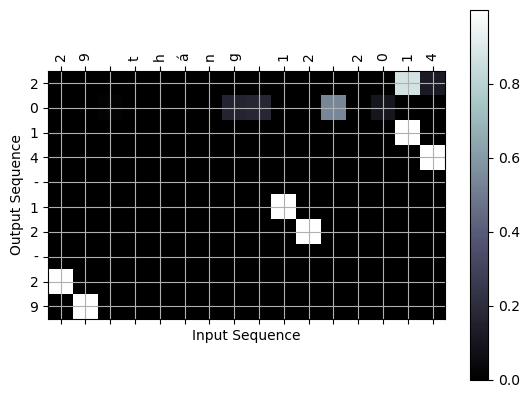

In [66]:
show_idx = randint(0, len(X_val))
text_x = decoder_sentence(X_val[show_idx, :].detach().cpu().numpy(), x_id2w)
text_y = decoder_sentence(preds[show_idx, :].detach().cpu().numpy(), y_id2w)
attn_weight = attn_weights[show_idx, :, -len(text_x):].detach().cpu()
show_attention(text_x, text_y, attn_weight)